In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle("../database/new_data.pkl")

In [3]:
target_distribution = df['target'].value_counts(normalize=True) * 100

In [4]:
target_distribution

0    96.142815
1     3.857185
Name: target, dtype: float64

In [5]:
# Desired ratio
ratio_1 = 0.4
desired_n_1 = int(len(df) * ratio_1)
desired_n_0 = len(df) - desired_n_1

In [6]:
desired_n_0, desired_n_1

(10251, 6834)

In [7]:
#Downsample the majority class (target = 0)
df_majority = df[df['target'] == 0].sample(n=desired_n_0, random_state=42)

In [8]:
#Upsample the minority class (target = 1) if necessary
df_minority = df[df['target'] == 1]

In [9]:
#combine to get 60/40
df = pd.concat([df_majority, df_minority.sample(n=desired_n_1, replace=True, random_state=42)])

In [10]:
#shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
target_distribution = df['target'].value_counts(normalize=True) * 100
target_distribution

0    60.0
1    40.0
Name: target, dtype: float64

In [12]:
df.head()

,loan_start_date,loan_end_date,loan_amount,interest_rate,branch,collateral_type,collateral_amount,credit_history_count,overdue_days,product,age,gender,education,occupation,marital_status,target
0,2019-03-18,2020-03-16,2000000,60.0,super branch,поручительство,4000000.0,2,40.0,006 - ишонч,27,ж,среднее,дехкон,разведен,0
1,2019-11-25,2022-02-19,19000000,60.0,super branch,золото,31700000.0,4,135.0,008 - сармоя (узок муддатли),31,ж,высшее,шофер-таксист,женат,1
2,2019-03-12,2021-10-12,17000000,57.6,super branch,машина,24300000.0,1,20.0,008 - сармоя (узок муддатли),28,м,среднее,дехкон,не женат,0
3,2022-04-18,2023-04-18,15000000,60.0,yaypan filiali,машина,21500000.0,1,3.0,009 - сармоя (киска муддатли),30,м,высшее,шофер-таксист,разведен,0
4,2020-07-06,2021-07-06,1000000,60.0,super branch,золото,1206500.0,1,116.0,007 - имкон (киска муддатли),58,ж,среднее,тикувчи,женат,1


In [13]:
df['loan_start_date'] = pd.to_datetime(df['loan_start_date'], errors='coerce')
df['loan_end_date'] = pd.to_datetime(df['loan_end_date'], errors='coerce')
df['loan_duration_days'] = (df['loan_end_date'] - df['loan_start_date']).dt.days

In [14]:
df['loan_duration_month'] = (df['loan_duration_days'] / 30).fillna(0).astype(int)

In [15]:
numerical_features = ['loan_amount', 'interest_rate', 'collateral_amount', 'age', 'credit_history_count', 'overdue_days']
categorical_features = ['branch', 'collateral_type', 'product', 'education', 'occupation', 'marital_status', 'gender']


In [16]:
df_clean = df[numerical_features + categorical_features + ['target']].dropna()

In [17]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
import pickle
pickle.dump(df, open('../database/new_data_normal.pkl','wb'))

In [20]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [21]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['loan_amount',
                                                   'interest_rate',
                                                   'collateral_amount', 'age',
                                                   'credit_history_count',
                                                   'overdue_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['branch', 'collateral_type',
                                                   'product', 'education',
                                                   'occupation',
                                                   'marital_status',
                                                   'gender'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [23]:
y_pred = pipeline.predict(X_test)

In [25]:
# AUC score
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score}")

AUC Score: 1.0


In [26]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


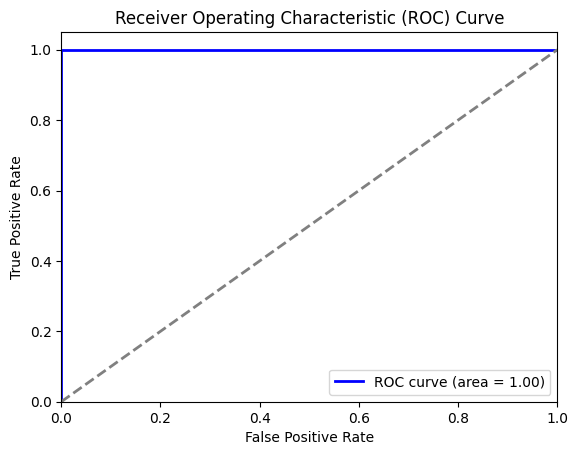

In [27]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
classification_report_result = classification_report(y_test, y_pred)
print(classification_report_result)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2050
           1       1.00      1.00      1.00      1367

    accuracy                           1.00      3417
   macro avg       1.00      1.00      1.00      3417
weighted avg       1.00      1.00      1.00      3417



In [29]:
import joblib
joblib.dump(pipeline, "../model/new_random_forest_model1.pkl")


['../model/new_random_forest_model1.pkl']

In [30]:
##feature importance

In [31]:
rf_classifier = pipeline.named_steps['classifier']

In [32]:
importances = rf_classifier.feature_importances_


In [33]:
numerical_importances = importances[:len(numerical_features)]


In [34]:
categorical_importances = []
for i, cat_feature in enumerate(categorical_features):
    start_index = len(numerical_features) + sum(
        [len(pipeline.named_steps['preprocessor'].transformers_[1][1].categories_[j]) for j in range(i)])
    end_index = start_index + len(pipeline.named_steps['preprocessor'].transformers_[1][1].categories_[i])
    average_importance = np.mean(importances[start_index:end_index])
    categorical_importances.append(average_importance)


In [35]:
feature_importance_dict = dict(zip(numerical_features, numerical_importances))
for i, cat_feature in enumerate(categorical_features):
    feature_importance_dict[cat_feature] = categorical_importances[i]


In [36]:
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)


In [37]:
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")


Feature Importance:
overdue_days: 0.7687
interest_rate: 0.0250
collateral_amount: 0.0246
loan_amount: 0.0228
age: 0.0221
credit_history_count: 0.0216
branch: 0.0055
marital_status: 0.0040
education: 0.0038
collateral_type: 0.0037
gender: 0.0036
occupation: 0.0033
product: 0.0018


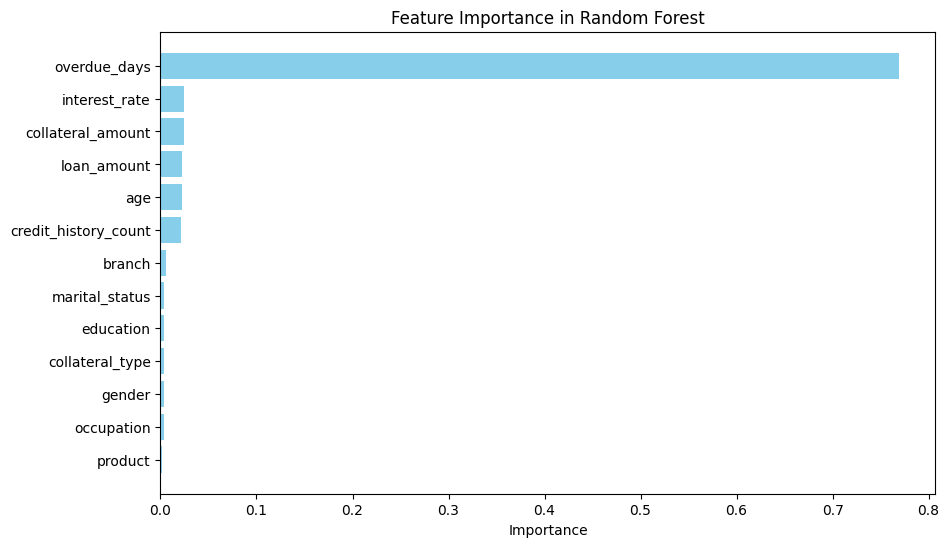

In [38]:
#feature importanse chart

plt.figure(figsize=(10, 6))
features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert to show highest importance at the top
plt.show()

In [39]:
#visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

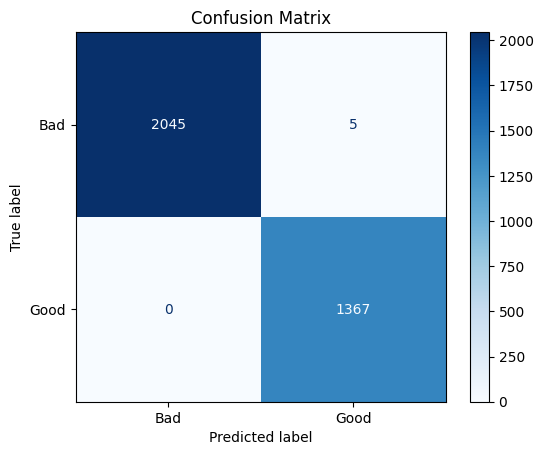

In [40]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=['Bad', 'Good'])
conf_matrix_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

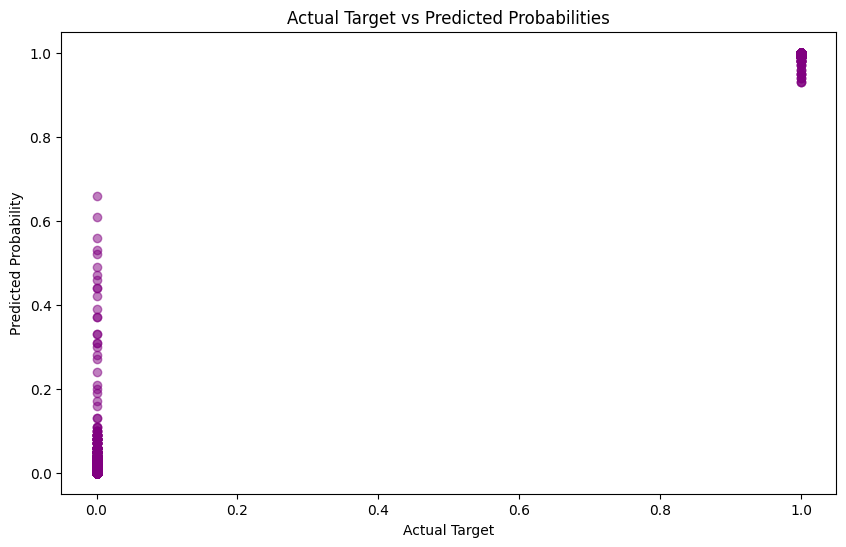

In [41]:
#Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_prob, alpha=0.5, color='purple')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Probability')
plt.title('Actual Target vs Predicted Probabilities')
plt.show()